In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

In [2]:
BASE_DIR = r"D:\1909term-thesis\thesis\ReviewsCrawler"
GENDER_FOLDERS = ["UNIQLO_female", "UNIQLO_male"]

# To store detailed info per CSV (product_id file)
csv_rows_info = []  # each item: dict with gender, category, file_name, num_reviews

# To store info aggregated per category
category_info = {}  # key: (gender, category), value: dict with counts

for gender in GENDER_FOLDERS:
    gender_path = os.path.join(BASE_DIR, gender)
    if not os.path.isdir(gender_path):
        print(f"Warning: {gender_path} does not exist, skipping.")
        continue

    # Each subfolder in gender_path is a product category
    for entry in os.scandir(gender_path):
        if not entry.is_dir():
            continue  # skip non-folders

        category = entry.name  # folder name is category
        category_path = entry.path

        # Initialize category record if not exists
        key = (gender, category)
        if key not in category_info:
            category_info[key] = {
                "gender": gender,
                "category": category,
                "num_product_ids": 0,
                "total_reviews_in_category": 0,
            }

        # List all CSV files in this category folder
        csv_files = [
            f for f in os.scandir(category_path)
            if f.is_file() and f.name.lower().endswith(".csv")
        ]

        for csv_entry in csv_files:
            csv_path = csv_entry.path
            file_name = csv_entry.name

            # Count number of rows (reviews) in this CSV
            try:
                df = pd.read_csv(csv_path)
                n_rows = len(df)
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")
                n_rows = 0

            # Assume each CSV file corresponds to one product_id
            category_info[key]["num_product_ids"] += 1
            category_info[key]["total_reviews_in_category"] += n_rows

            csv_rows_info.append({
                "gender": gender,
                "category": category,
                "file_name": file_name,
                "num_reviews_in_file": n_rows,
            })

category_df = pd.DataFrame(category_info.values())
csv_df = pd.DataFrame(csv_rows_info)

# ---- Overall stats ----
if not category_df.empty:
    total_categories = len(category_df)
    total_reviews = int(category_df["total_reviews_in_category"].sum())
    total_product_ids = int(category_df["num_product_ids"].sum())
else:
    total_categories = total_reviews = total_product_ids = 0

print("\n===== Overall Summary =====")
print(f"Total product categories (across female & male): {total_categories}")
print(f"Total product_ids (CSV files): {total_product_ids}")
print(f"Total number of reviews (rows): {total_reviews}")

# ---- Per-gender stats (female vs male) ----
if not category_df.empty:
    gender_summary = (
        category_df
        .groupby("gender", as_index=False)
        .agg(
            num_categories=("category", "nunique"),
            num_product_ids=("num_product_ids", "sum"),
            total_reviews=("total_reviews_in_category", "sum"),
        )
    )

    print("\n===== Per-gender summary =====")
    print(gender_summary.to_string(index=False))

    for _, row in gender_summary.iterrows():
        print(
            f"{row['gender']}: {row['num_product_ids']} product_ids, "
            f"{row['total_reviews']} reviews across {row['num_categories']} categories"
        )
else:
    print("\nNo categories found in category_df – please check your folder structure or BASE_DIR.")

print("\n===== Categories (folder names) =====")
if not category_df.empty:
    print(
        category_df[["gender", "category"]]
        .sort_values(["gender", "category"])
        .to_string(index=False)
    )
else:
    print("No category data.")

print("\n===== Per-category summary =====")
if not category_df.empty:
    print(
        category_df
        .sort_values(["gender", "category"])
        .to_string(index=False)
    )
else:
    print("No per-category data.")

print("\n===== Per-CSV (product_id) summary (first 20 rows) =====")
if not csv_df.empty:
    print(csv_df.head(20).to_string(index=False))
else:
    print("No CSV-level data.")


===== Overall Summary =====
Total product categories (across female & male): 16
Total product_ids (CSV files): 640
Total number of reviews (rows): 55005

===== Per-gender summary =====
       gender  num_categories  num_product_ids  total_reviews
UNIQLO_female              10              407          32504
  UNIQLO_male               6              233          22501
UNIQLO_female: 407 product_ids, 32504 reviews across 10 categories
UNIQLO_male: 233 product_ids, 22501 reviews across 6 categories

===== Categories (folder names) =====
       gender               category
UNIQLO_female  UNIQLO_T-shirt_female
UNIQLO_female   UNIQLO_blouse_female
UNIQLO_female     UNIQLO_coat_female
UNIQLO_female    UNIQLO_dress_female
UNIQLO_female    UNIQLO_jeans_female
UNIQLO_female   UNIQLO_jersey_female
UNIQLO_female UNIQLO_knitwear_female
UNIQLO_female    UNIQLO_pants_female
UNIQLO_female UNIQLO_roomwear_female
UNIQLO_female    UNIQLO_skirt_female
  UNIQLO_male    UNIQLO_T-shirt_male
  UNIQLO_male 

In [4]:
# ======== Data Cleaning ========
REVIEW_COL = "rateContent"
PLACEHOLDER_TEXT = "此用户没有填写评论!"

# ========= Step 1: Load all raw reviews =========
all_rows = []

for gender in GENDER_FOLDERS:
    gender_path = os.path.join(BASE_DIR, gender)
    if not os.path.isdir(gender_path):
        print(f"Warning: {gender_path} does not exist, skipping.")
        continue

    for entry in os.scandir(gender_path):
        if not entry.is_dir():
            continue

        category = entry.name
        category_path = entry.path

        csv_files = [
            f for f in os.scandir(category_path)
            if f.is_file() and f.name.lower().endswith(".csv")
        ]

        for csv_entry in csv_files:
            csv_path = csv_entry.path
            file_name = csv_entry.name

            try:
                try:
                    df = pd.read_csv(csv_path, encoding="utf-8")
                except UnicodeDecodeError:
                    df = pd.read_csv(csv_path, encoding="gb18030")
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")
                continue

            # Ensure rateContent + rateDate exist
            if REVIEW_COL not in df.columns or "rateDate" not in df.columns:
                print(f"Missing required columns in {csv_path}. Found: {df.columns}")
                continue

            # Extract both review content & date
            for idx, row in df.iterrows():
                all_rows.append({
                    "gender": gender,
                    "category": category,
                    "file_name": file_name,
                    "rateDate": str(row["rateDate"]).strip(),
                    "review_text": str(row[REVIEW_COL]).strip()
                })

# Convert to DataFrame
all_reviews_df = pd.DataFrame(all_rows)
print(f"\nTotal raw reviews loaded: {len(all_reviews_df)}")

# ========= Step 2: Count placeholder “no review” cases =========
mask_placeholder = all_reviews_df["review_text"] == PLACEHOLDER_TEXT
num_placeholder = mask_placeholder.sum()

print(f"\nNumber of '此用户没有填写评论!': {num_placeholder}")
print(f"Number of valid reviews: {total_reviews-num_placeholder}")

# Convert rateDate to datetime
all_reviews_df["rateDate_parsed"] = pd.to_datetime(
    all_reviews_df["rateDate"],
    errors="coerce"  # convert invalid dates to NaT
)

# Drop rows where date failed to parse
num_invalid_dates = all_reviews_df["rateDate_parsed"].isna().sum()
if num_invalid_dates > 0:
    print(f"\nWarning: {num_invalid_dates} rows had invalid date format.")

# ====== Compute date range ======
min_date = all_reviews_df["rateDate_parsed"].min()
max_date = all_reviews_df["rateDate_parsed"].max()
span_days = (max_date - min_date).days

print("\n===== Review Date Range =====")
print(f"Earliest review: {min_date}")
print(f"Latest review:   {max_date}")
print(f"Time span:       {span_days} days (~{span_days/30:.1f} months, ~{span_days/365:.2f} years)")


Total raw reviews loaded: 55005

Number of '此用户没有填写评论!': 1852
Number of valid reviews: 53153

===== Review Date Range =====
Earliest review: 2019-07-29 17:37:37
Latest review:   2021-03-05 13:40:49
Time span:       584 days (~19.5 months, ~1.60 years)



Review length statistics:
count    55005.000000
mean        20.933715
std         32.076451
min          1.000000
25%          5.000000
50%         12.000000
75%         24.000000
max       1932.000000
Name: review_length, dtype: float64

===== Review Length Range Statistics =====
Reviews with length 100–500 chars:   1379
Reviews with length 500–1000 chars:  3
Reviews with length >1000 chars:     3

Percentage Breakdown:
100–500 chars:   2.51%
500–1000 chars:  0.01%
>1000 chars:     0.01%


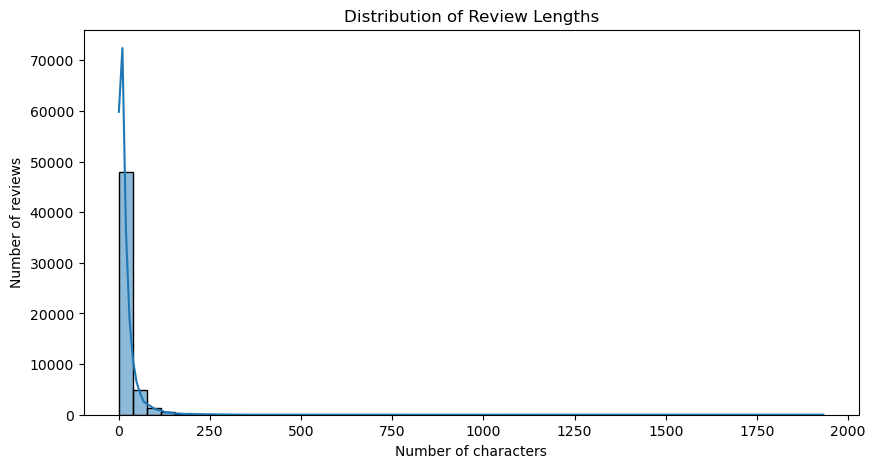

In [6]:
# ========= Step 3: Compute review length (in characters) =========
all_reviews_df["review_length"] = all_reviews_df["review_text"].apply(len)

print("\nReview length statistics:")
print(all_reviews_df["review_length"].describe())

len_100_500 = all_reviews_df[(all_reviews_df["review_length"] >= 100) &
                             (all_reviews_df["review_length"] < 500)].shape[0]

len_500_1000 = all_reviews_df[(all_reviews_df["review_length"] >= 500) &
                              (all_reviews_df["review_length"] < 1000)].shape[0]

len_over_1000 = all_reviews_df[(all_reviews_df["review_length"] >= 1000)].shape[0]

print("\n===== Review Length Range Statistics =====")
print(f"Reviews with length 100–500 chars:   {len_100_500}")
print(f"Reviews with length 500–1000 chars:  {len_500_1000}")
print(f"Reviews with length >1000 chars:     {len_over_1000}")

# compute percentages
total_reviews = len(all_reviews_df)
print("\nPercentage Breakdown:")
print(f"100–500 chars:   {len_100_500 / total_reviews:.2%}")
print(f"500–1000 chars:  {len_500_1000 / total_reviews:.2%}")
print(f">1000 chars:     {len_over_1000 / total_reviews:.2%}")

# ========= Step 4: Visualize length distribution =========
plt.figure(figsize=(10, 5))
sns.histplot(all_reviews_df["review_length"], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Number of reviews")
plt.show()

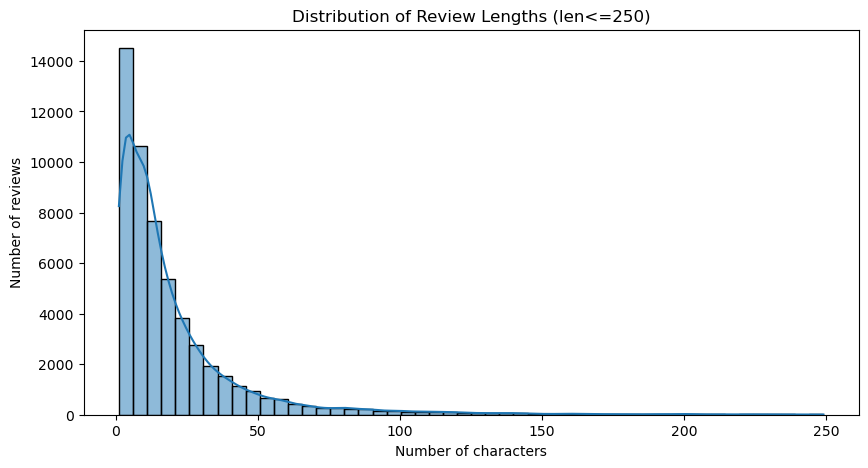

In [7]:
#========visualize length distribution for reviews len <= 250
reviews_below_250 = all_reviews_df[(all_reviews_df["review_length"] <= 250)]

plt.figure(figsize=(10, 5))
sns.histplot(reviews_below_250["review_length"], bins=50, kde=True)
plt.title("Distribution of Review Lengths (len<=250)")
plt.xlabel("Number of characters")
plt.ylabel("Number of reviews")
plt.show()

In [8]:
# ========= Show reviews longer than 1000 chars =========
long_reviews_df = all_reviews_df[all_reviews_df["review_length"] >= 1000].copy()

# Show the first few long reviews
print("\n===== Examples of reviews longer than 1000 characters =====")
print(long_reviews_df[["gender", "category", "file_name", "review_length", "review_text"]]
      .head(10)
      .to_string(index=False))


===== Examples of reviews longer than 1000 characters =====
       gender               category                    file_name  review_length                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [9]:
# ========= Show reviews shorter than 3 chars =========
short_reviews_df = all_reviews_df[all_reviews_df["review_length"] <= 3].copy()
len_3_shorter=short_reviews_df.shape[0]

print(f"Reviews with length shorter than 3 chars: {len_3_shorter}")
print("\nPercentage Breakdown:")
print(f"<3 chars:   {len_3_shorter / total_reviews:.2%}")

# Show the first few short reviews
print("\n===== Examples of reviews shorter than 3 characters =====")
print(short_reviews_df[["gender", "category", "file_name", "review_length", "review_text"]]
      .head(10)
      .to_string(index=False))

Reviews with length shorter than 3 chars: 10207

Percentage Breakdown:
<3 chars:   18.56%

===== Examples of reviews shorter than 3 characters =====
       gender             category               file_name  review_length review_text
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              2          不错
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              3         质量好
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              1           好
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              3         舒服～
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              2          挺好
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              3         很好👌
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              2          还行
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              2          舒服
UNIQLO_female UNIQLO_blouse_female blouse_611817827239.csv              1    

In [14]:
# valid reviews: not placeholder, length > 3 and < 1000
valid_mask = (
    (all_reviews_df["review_text"] != PLACEHOLDER_TEXT) &
    (all_reviews_df["review_length"] > 3) &
    (all_reviews_df["review_length"] < 1000)
)

valid_reviews_df = all_reviews_df[valid_mask].copy()

#drop duplicates
dup_subset = ["gender", "category", "file_name", "rateDate", "review_text"]
valid_reviews_df = valid_reviews_df.drop_duplicates(subset=dup_subset)

print(f"Valid reviews: {len(valid_reviews_df)}")

Valid reviews: 42118


In [17]:
valid_reviews_df.head(10)

,gender,category,file_name,rateDate,review_text,rateDate_parsed,review_length
1,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2021-01-08 07:59:09,一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...,2021-01-08 07:59:09,65
2,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-12-13 21:21:05,质地很柔软，不是容易皱的材质，等天气暖了穿,2020-12-13 21:21:05,21
3,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-16 12:31:51,好看面料舒服,2020-09-16 12:31:51,6
4,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-15 19:29:21,我觉得一般,2020-09-15 19:29:21,5
5,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-13 22:10:05,U家的T恤穿M码的，但是衬衣买M的有点紧了，下次要买大一码，质量不错，穿着舒服,2020-09-13 22:10:05,39
6,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-13 00:52:55,本来出差前四五天就拍了，打算出差开会穿。结果一直没发货，等我出差回来取件的，可想而知经历了多...,2020-09-13 00:52:55,101
7,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-08 10:19:28,第一次购买，问了一下客服，感谢客服的建议。尺寸大小非常合适。以后会常来。,2020-09-08 10:19:28,36
8,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-07 21:49:40,款式喜欢，就是掉色太厉害了,2020-09-07 21:49:40,13
10,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-03 10:44:13,衣服很好舒服，喜欢,2020-09-03 10:44:13,9
11,UNIQLO_female,UNIQLO_blouse_female,blouse_611817827239.csv,2020-09-02 16:31:40,衣服大小合适，颜色也很正，很喜欢,2020-09-02 16:31:40,16


In [18]:
def split_clauses_zh(text):
    """
    Split Chinese text into short clauses using punctuation.
    """
    if not isinstance(text, str):
        return []

    text = text.replace("\n", "").strip()
    if not text:
        return []

    # Strong sentence delimiters: end of sentence
    sentence_delimiters = r"[。！？!?；;]+"
    rough_sentences = re.split(sentence_delimiters, text)

    clauses = []
    for sent in rough_sentences:
        sent = sent.strip()
        if not sent:
            continue

        # Lighter delimiters inside a sentence
        sub_clauses = re.split(r"[，、,]+", sent)
        for c in sub_clauses:
            c = c.strip()
            if c:
                clauses.append(c)

    return clauses

In [19]:
# Random sample 400 reviews
sample_reviews_df = valid_reviews_df.sample(n=400, random_state=42).copy()

# Apply to valid reviews & sample
valid_reviews_df["clauses"] = valid_reviews_df["review_text"].apply(split_clauses_zh)
sample_reviews_df["clauses"] = sample_reviews_df["review_text"].apply(split_clauses_zh)

# One row per clause
clauses_df = valid_reviews_df.explode("clauses").dropna(subset=["clauses"]).copy()
clauses_df = clauses_df.rename(columns={"clauses": "clause"})

sample_reviews_df = sample_reviews_df.explode("clauses").dropna(subset=["clauses"]).copy()
sample_reviews_df = sample_reviews_df.rename(columns={"clauses": "clause"})

print(f"Total clauses from valid reviews: {len(clauses_df)}")
print(f"Total clauses from sample reviews: {len(sample_reviews_df)}")
print(clauses_df[["gender", "category", "review_text", "clause"]].head(10))

Total clauses from valid reviews: 132514
Total clauses from sample reviews: 1075
          gender              category  \
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   
1  UNIQLO_female  UNIQLO_blouse_female   

                                         review_text      clause  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...    一直喜欢这件衣服  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...       一直不降价  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...       终于逮住了  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...         特卖会  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...        79买的  
1  一直喜欢这件衣服，一直不降价，终于逮住了，特卖会，79买的，真香，留着开春穿，优衣库的衣服真...  

In [23]:
#========= Random sample all clauses ==========
# 1. Sample a subset for labeling
N_SAMPLE = len(sample_reviews_df)
sample_df = clauses_df.sample(n=N_SAMPLE, random_state=42).copy()

# 2. Create an empty 'domain' column for manual label
sample_df["domain"] = ""
sample_reviews_df["domain"] = ""

# 3. Save samples for labeling
sample_df.to_csv(fr"{BASE_DIR}\sample_df.csv", index=False, encoding="utf-8-sig")
sample_reviews_df.to_csv(fr"{BASE_DIR}\sample_reviews_df.csv", index=False, encoding="utf-8-sig")

In [27]:
#======== Domain distribution ========
df_labeled_clauses = pd.read_csv(fr"{BASE_DIR}\sample_df_labeled.csv")
df_labeled_reviews_clauses = pd.read_csv(fr"{BASE_DIR}\sample_reviews_df_labeled.csv")

#Dataset 1: Review-Based Sample
counts = df_labeled_clauses['domain'].value_counts()
proportions = df_labeled_clauses['domain'].value_counts(normalize=True)

print("#======== Dataset 1: Review-Based Sample =========")
print("Counts:\n", counts)
print("\nProportions:\n", proportions)

#Dataset 2: Clause-Based Sample
counts = df_labeled_reviews_clauses['domain'].value_counts()
proportions = df_labeled_reviews_clauses['domain'].value_counts(normalize=True)

print("\n======== Dataset 2: Clause-Based Sample =========")
print("Counts:\n", counts)
print("\nProportions:\n", proportions)

#======== Dataset 1: Review-Based Sample =========
Counts:
 domain
Other                   721
Product Quality         190
Size & Fit              143
Aesthetic Attributes    139
Value Perception         48
Functionality            44
Name: count, dtype: int64

Proportions:
 domain
Other                   0.561089
Product Quality         0.147860
Size & Fit              0.111284
Aesthetic Attributes    0.108171
Value Perception        0.037354
Functionality           0.034241
Name: proportion, dtype: float64

======== Dataset 2: Clause-Based Sample =========
Counts:
 domain
Other                   732
Product Quality         234
Aesthetic Attributes    124
Size & Fit              117
Value Perception         42
Functionality            36
Name: count, dtype: int64

Proportions:
 domain
Other                   0.569650
Product Quality         0.182101
Aesthetic Attributes    0.096498
Size & Fit              0.091051
Value Perception        0.032685
Functionality           0.028016
Name:

In [25]:
#======== build training and testing datasets ========
#======== random sample clauses =========
train_df, test_df = train_test_split(
    df_labeled_clauses,
    test_size=0.2,
    random_state=42,
    stratify=df_labeled_clauses["domain"]
)

print("#======== random sample clauses =========")
print("\nTraining samples:", len(train_df))
print("Testing samples:", len(test_df))

print("\nTraining label distribution:")
print(train_df["domain"].value_counts())
print("\nTraining label proportion:")
print(train_df["domain"].value_counts(normalize=True))

print("\nTesting label distribution:")
print(test_df["domain"].value_counts())
print("\nTesting label proportion:")
print(test_df["domain"].value_counts(normalize=True))

#======== clauses sample from complete reviews =========
train_review_df, test_review_df = train_test_split(
    df_labeled_reviews_clauses,
    test_size=0.2,
    random_state=42,
    stratify=df_labeled_reviews_clauses["domain"]
)

print("\n\n#========  clauses sample from complete reviews =========")
print("\nTraining samples:", len(train_review_df))
print("Testing samples:", len(test_review_df))

print("\nTraining label distribution:")
print(train_review_df["domain"].value_counts())
print("\nTraining label proportion:")
print(train_review_df["domain"].value_counts(normalize=True))

print("\nTesting label distribution:")
print(test_review_df["domain"].value_counts())
print("\nTesting label proportion:")
print(test_review_df["domain"].value_counts(normalize=True))

#======== random sample clauses =========

Training samples: 1028
Testing samples: 257

Training label distribution:
domain
Other                   577
Product Quality         152
Size & Fit              114
Aesthetic Attributes    111
Value Perception         39
Functionality            35
Name: count, dtype: int64

Training label proportion:
domain
Other                   0.561284
Product Quality         0.147860
Size & Fit              0.110895
Aesthetic Attributes    0.107977
Value Perception        0.037938
Functionality           0.034047
Name: proportion, dtype: float64

Testing label distribution:
domain
Other                   144
Product Quality          38
Size & Fit               29
Aesthetic Attributes     28
Functionality             9
Value Perception          9
Name: count, dtype: int64

Testing label proportion:
domain
Other                   0.560311
Product Quality         0.147860
Size & Fit              0.112840
Aesthetic Attributes    0.108949
Functionality       

In [15]:
# Create label ↔ id mapping
labels = sorted(df_labeled_clauses["domain"].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
num_labels = len(labels)

print(label2id)

train_id_df = train_df.copy()
test_id_df = test_df.copy()
train_id_df["label_id"] = train_id_df["domain"].map(label2id)
test_id_df["label_id"] = test_id_df["domain"].map(label2id)

train_review_id_df = train_review_df.copy()
test_review_id_df = test_review_df.copy()
train_review_id_df["label_id"] = train_review_id_df["domain"].map(label2id)
test_review_id_df["label_id"] = test_review_id_df["domain"].map(label2id)

{'Aesthetic Attributes': 0, 'Functionality': 1, 'Other': 2, 'Product Quality': 3, 'Size & Fit': 4, 'Value Perception': 5}


In [26]:
# ==== Tokenizer & basic settings ====
pretrained_model_name = "bert-base-chinese"
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name)

MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ==== Compute class weights from a training df ====
def compute_class_weights(train_df, num_labels):
    """
    Compute class weights from a training DataFrame with a 'label_id' column.
    Returns a torch.FloatTensor of shape [num_labels].
    """
    label_counts = Counter(train_df["label_id"].tolist())
    print("Train label counts:", label_counts)

    total = sum(label_counts.values())
    weights = []

    for label_id in range(num_labels):
        # if a label is missing in this dataset, treat its count as 1 to avoid division by zero
        count = label_counts.get(label_id, 1)
        weight = total / (num_labels * count)  # larger weight for smaller classes
        weights.append(weight)

    print("Class weights:", weights)
    return torch.tensor(weights, dtype=torch.float)

Using device: cpu


In [27]:
# ==== Dataset ====
class ClauseDataset(Dataset):
    def __init__(self, df):
        self.texts = df["clause"].astype(str).tolist()
        self.labels = df["label_id"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        item = {key: val.squeeze(0) for key, val in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# ==== training function ====
def train_bert_classifier(
    train_loader,
    num_labels,
    id2label,
    label2id,
    class_weights,           # torch tensor
    pretrained_model_name,
    epochs=4,
    learning_rate=2e-5,
    device=None,
    tag=""
):
    """
    Train a BERT classifier on a given DataLoader and return the trained model.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"[{tag}] Using device:", device)

    # Build model
    model = BertForSequenceClassification.from_pretrained(
        pretrained_model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )
    model.to(device)

    # Optimizer & scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    weight_tensor = class_weights.to(device) if class_weights is not None else None
    loss_fn = torch.nn.CrossEntropyLoss(weight=weight_tensor)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch in tqdm(train_loader, desc=f"[{tag}] Training epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            optimizer.zero_grad()

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids", None),
            )

            logits = outputs.logits
            loss = loss_fn(logits, labels)
            loss.backward()

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"[{tag}] Epoch {epoch+1} training loss: {avg_loss:.4f}")

    return model

In [28]:
train_dataset_1 = ClauseDataset(train_id_df)
test_dataset_1 = ClauseDataset(test_id_df)

train_dataset_2 = ClauseDataset(train_review_id_df)
test_dataset_2 = ClauseDataset(test_review_id_df)

BATCH_SIZE = 16

train_loader_1 = DataLoader(train_dataset_1, batch_size=BATCH_SIZE, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=BATCH_SIZE, shuffle=False)

train_loader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
# ==== Compute class weights for each training set ====
class_weights_1 = compute_class_weights(train_id_df,        num_labels)
class_weights_2 = compute_class_weights(train_review_id_df, num_labels)


# ==== Train model on random sample clauses (dataset 1) ====
model_1 = train_bert_classifier(
    train_loader=train_loader_1,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    class_weights=class_weights_1,
    pretrained_model_name=pretrained_model_name,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    tag="dataset_1"
)

Train label counts: Counter({2: 577, 3: 152, 4: 114, 0: 111, 5: 39, 1: 35})
Class weights: [1.5435435435435436, 4.895238095238096, 0.29693818601964184, 1.1271929824561404, 1.5029239766081872, 4.3931623931623935]
Train label counts: Counter({2: 586, 3: 187, 0: 99, 4: 93, 5: 34, 1: 29})
Class weights: [1.7306397306397305, 5.908045977011494, 0.2923777019340159, 0.9162210338680927, 1.842293906810036, 5.03921568627451]
[dataset_1] Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_1] Training epoch 1/4: 100%|██████████| 65/65 [04:42<00:00,  4.34s/it]


[dataset_1] Epoch 1 training loss: 1.6654


[dataset_1] Training epoch 2/4: 100%|██████████| 65/65 [04:32<00:00,  4.20s/it]


[dataset_1] Epoch 2 training loss: 0.8608


[dataset_1] Training epoch 3/4: 100%|██████████| 65/65 [04:27<00:00,  4.12s/it]


[dataset_1] Epoch 3 training loss: 0.4285


[dataset_1] Training epoch 4/4: 100%|██████████| 65/65 [04:28<00:00,  4.12s/it]

[dataset_1] Epoch 4 training loss: 0.2826


In [33]:
# ==== Train model on clauses from random sample reviews (dataset 2) ====
model_2 = train_bert_classifier(
    train_loader=train_loader_2,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    class_weights=class_weights_2,
    pretrained_model_name=pretrained_model_name,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    tag="dataset_2"
)

[dataset_2] Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_2] Training epoch 1/4: 100%|██████████| 65/65 [04:46<00:00,  4.41s/it]


[dataset_2] Epoch 1 training loss: 1.6273


[dataset_2] Training epoch 2/4: 100%|██████████| 65/65 [04:44<00:00,  4.38s/it]


[dataset_2] Epoch 2 training loss: 0.7952


[dataset_2] Training epoch 3/4: 100%|██████████| 65/65 [04:44<00:00,  4.38s/it]


[dataset_2] Epoch 3 training loss: 0.4132


[dataset_2] Training epoch 4/4: 100%|██████████| 65/65 [04:31<00:00,  4.17s/it]

[dataset_2] Epoch 4 training loss: 0.3025


In [34]:
#========== Model evaluation ==========
def evaluate_model(model, test_loader, id2label, num_labels, device, tag=""):
    model.eval()
    all_preds = []
    all_true = []

    with torch.inference_mode():  # or torch.no_grad()
        for batch in tqdm(test_loader, desc=f"[{tag}] Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids", None),
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_true.extend(labels.cpu().tolist())

    print(f"\n===== Test set performance ({tag}) =====")
    print(classification_report(
        all_true,
        all_preds,
        target_names=[id2label[i] for i in range(num_labels)],
        digits=3
    ))

In [35]:
# For dataset 1
evaluate_model(
    model=model_1,
    test_loader=test_loader_1,
    id2label=id2label,
    num_labels=num_labels,
    device=device,
    tag="dataset_1"
)

[dataset_1] Evaluating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


===== Test set performance (dataset_1) =====
                      precision    recall  f1-score   support

Aesthetic Attributes      0.735     0.893     0.806        28
       Functionality      0.333     0.556     0.417         9
               Other      0.942     0.785     0.856       144
     Product Quality      0.810     0.895     0.850        38
          Size & Fit      0.694     0.862     0.769        29
    Value Perception      0.900     1.000     0.947         9

            accuracy                          0.821       257
           macro avg      0.736     0.832     0.774       257
        weighted avg      0.849     0.821     0.828       257



In [36]:
# For dataset 2
evaluate_model(
    model=model_2,
    test_loader=test_loader_2,
    id2label=id2label,
    num_labels=num_labels,
    device=device,
    tag="dataset_2"
)

[dataset_2] Evaluating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


===== Test set performance (dataset_2) =====
                      precision    recall  f1-score   support

Aesthetic Attributes      0.800     0.960     0.873        25
       Functionality      0.556     0.714     0.625         7
               Other      0.962     0.856     0.906       146
     Product Quality      0.816     0.851     0.833        47
          Size & Fit      0.645     0.833     0.727        24
    Value Perception      0.875     0.875     0.875         8

            accuracy                          0.860       257
           macro avg      0.776     0.848     0.807       257
        weighted avg      0.876     0.860     0.864       257



In [37]:
#========== manual assigned class weight =============
class_weights = torch.tensor([1, 3, 0.5, 1, 2.5, 3], dtype=torch.float)

# ==== Train model on random sample clauses (dataset 1) ====
model_1_1 = train_bert_classifier(
    train_loader=train_loader_1,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    class_weights=class_weights,
    pretrained_model_name=pretrained_model_name,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    tag="dataset_1"
)

[dataset_1] Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_1] Training epoch 1/4: 100%|██████████| 65/65 [04:47<00:00,  4.43s/it]


[dataset_1] Epoch 1 training loss: 1.5640


[dataset_1] Training epoch 2/4: 100%|██████████| 65/65 [04:45<00:00,  4.39s/it]


[dataset_1] Epoch 2 training loss: 0.8002


[dataset_1] Training epoch 3/4: 100%|██████████| 65/65 [04:31<00:00,  4.17s/it]


[dataset_1] Epoch 3 training loss: 0.4408


[dataset_1] Training epoch 4/4: 100%|██████████| 65/65 [04:29<00:00,  4.15s/it]

[dataset_1] Epoch 4 training loss: 0.2879


In [49]:
# ==== Train model on clauses from random sample reviews (dataset 2) ====
model_2_1 = train_bert_classifier(
    train_loader=train_loader_2,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    class_weights=class_weights,
    pretrained_model_name=pretrained_model_name,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    tag="dataset_2"
)

[dataset_2] Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[dataset_2] Training epoch 1/4: 100%|██████████| 65/65 [04:15<00:00,  3.93s/it]


[dataset_2] Epoch 1 training loss: 1.5687


[dataset_2] Training epoch 2/4: 100%|██████████| 65/65 [04:19<00:00,  4.00s/it]


[dataset_2] Epoch 2 training loss: 0.7903


[dataset_2] Training epoch 3/4: 100%|██████████| 65/65 [04:59<00:00,  4.60s/it]


[dataset_2] Epoch 3 training loss: 0.3393


[dataset_2] Training epoch 4/4: 100%|██████████| 65/65 [04:26<00:00,  4.10s/it]

[dataset_2] Epoch 4 training loss: 0.1966


In [50]:
#model evaluation
# For dataset 1
evaluate_model(
    model=model_1_1,
    test_loader=test_loader_1,
    id2label=id2label,
    num_labels=num_labels,
    device=device,
    tag="dataset_1"
)

# For dataset 2
evaluate_model(
    model=model_2_1,
    test_loader=test_loader_2,
    id2label=id2label,
    num_labels=num_labels,
    device=device,
    tag="dataset_2"
)

[dataset_1] Evaluating: 100%|██████████| 17/17 [00:22<00:00,  1.34s/it]



===== Test set performance (dataset_1) =====
                      precision    recall  f1-score   support

Aesthetic Attributes      0.839     0.929     0.881        28
       Functionality      0.556     0.556     0.556         9
               Other      0.937     0.826     0.878       144
     Product Quality      0.875     0.921     0.897        38
          Size & Fit      0.650     0.897     0.754        29
    Value Perception      0.900     1.000     0.947         9

            accuracy                          0.856       257
           macro avg      0.793     0.855     0.819       257
        weighted avg      0.870     0.856     0.858       257



[dataset_2] Evaluating: 100%|██████████| 17/17 [00:23<00:00,  1.37s/it]


===== Test set performance (dataset_2) =====
                      precision    recall  f1-score   support

Aesthetic Attributes      0.857     0.960     0.906        25
       Functionality      1.000     0.714     0.833         7
               Other      0.965     0.932     0.948       146
     Product Quality      0.913     0.894     0.903        47
          Size & Fit      0.714     0.833     0.769        24
    Value Perception      0.889     1.000     0.941         8

            accuracy                          0.914       257
           macro avg      0.890     0.889     0.883       257
        weighted avg      0.920     0.914     0.916       257



In [51]:
#========== generate predictions on all clauses ============
#load tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name)

class ReviewClauseDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]["clause"])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

In [52]:
#dataset & loader for all clauses
full_dataset = ReviewClauseDataset(clauses_df, tokenizer)
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

model = model_2_1
model.to(device)
model.eval()

all_preds = []

#prediction loop
with torch.inference_mode():
    for batch in full_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().tolist())

#map predicted ids -> label names
predicted_labels = [id2label[int(p)] for p in all_preds]

#attach predictions
clauses_df["domain_pred"] = predicted_labels

In [53]:
#Save template for labeling
clauses_df.to_csv(fr"{BASE_DIR}\clauses_pred_label.csv", index=False, encoding="utf-8-sig")